# Linear Regression Slope Indicator

**Formula**: Linear regression slope over rolling window

**Use Cases:**
- Trend direction (positive = up, negative = down)
- Trend strength (magnitude)
- Acceleration/deceleration detection
- Divergence analysis

**Performance**: 50-100x faster than scipy (Numba-optimized)

In [1]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from indikator import slope

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## Scenario 1: Trend Direction Detection
How slope identifies uptrends, downtrends, and consolidation

/tmp/sselcuk/ipykernel_1244539/2923772788.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


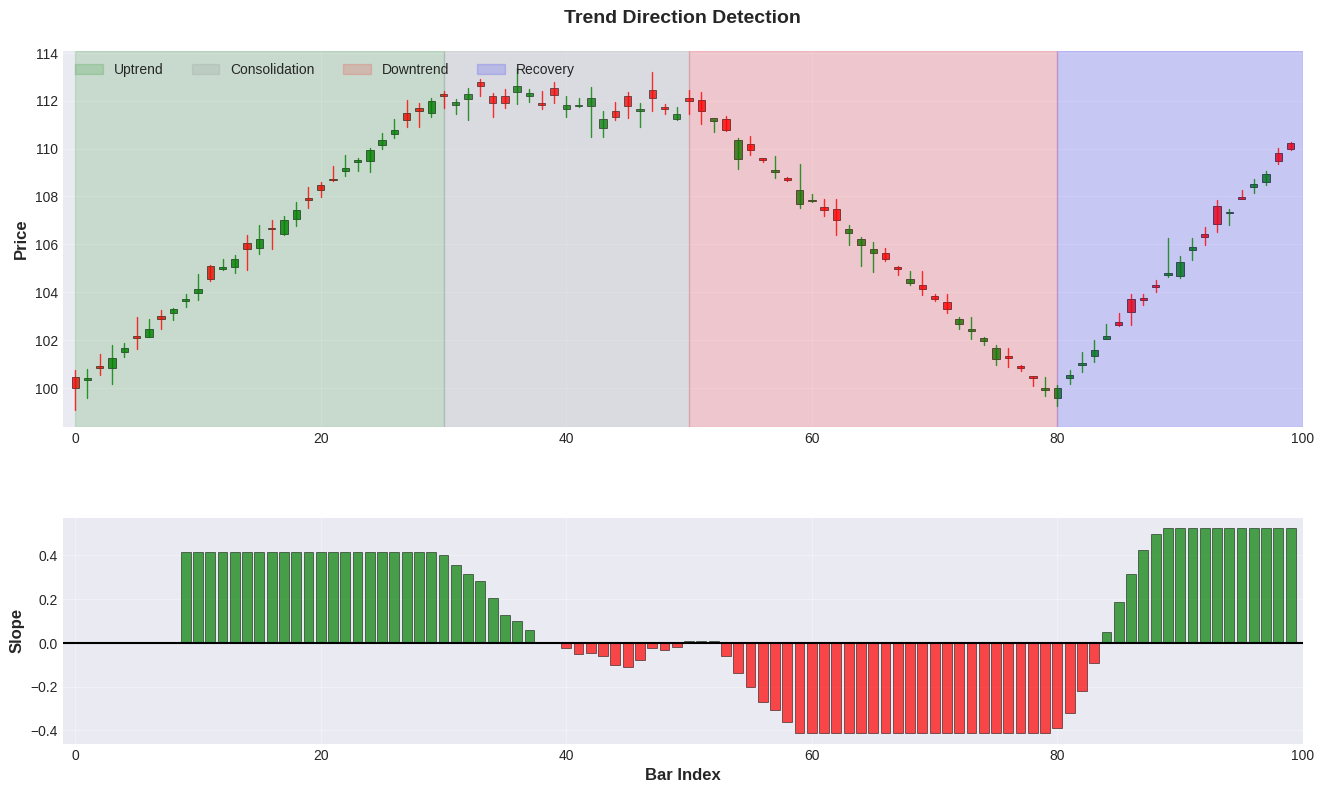

Slope by Phase:
  Uptrend (0-30):      0.4138
  Consolidation (30-50): 0.0657
  Downtrend (50-80):   -0.3334
  Recovery (80-100):   0.3120


In [2]:
# Create multi-phase price data
n = 100
dates = pd.date_range('2024-01-01 09:30', periods=n, freq='5min')

# Different trend phases
uptrend = np.linspace(100, 112, 30)
consolidation = 112 + np.random.randn(20) * 0.4
downtrend = np.linspace(112, 100, 30)
recovery = np.linspace(100, 110, 20)
closes = np.concatenate([uptrend, consolidation, downtrend, recovery])

# Create OHLC
opens = closes + np.random.randn(n) * 0.3
highs = np.maximum(opens, closes) + np.abs(np.random.randn(n)) * 0.4
lows = np.minimum(opens, closes) - np.abs(np.random.randn(n)) * 0.4
volumes = 1000 + np.abs(np.random.randn(n)) * 200

df = pd.DataFrame({'open': opens, 'high': highs, 'low': lows, 'close': closes, 'volume': volumes}, index=dates)
result = slope(df["close"], window=10)

# Plot
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(2, 1, height_ratios=[2.5, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Candlesticks
for i in range(len(df)):
    color = 'green' if df['close'].iloc[i] >= df['open'].iloc[i] else 'red'
    ax1.plot([i, i], [df['low'].iloc[i], df['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(df['close'].iloc[i] - df['open'].iloc[i])
    if height < 0.05: height = 0.1
    bottom = min(df['open'].iloc[i], df['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

# Highlight phases
ax1.axvspan(0, 30, alpha=0.15, color='green', label='Uptrend')
ax1.axvspan(30, 50, alpha=0.15, color='gray', label='Consolidation')
ax1.axvspan(50, 80, alpha=0.15, color='red', label='Downtrend')
ax1.axvspan(80, 100, alpha=0.15, color='blue', label='Recovery')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Trend Direction Detection', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', ncol=4, fontsize=10)
ax1.set_xlim(-1, len(df))

# Slope
colors_slope = ['green' if s > 0 else 'red' if s < 0 else 'gray' for s in result.fillna(0)]
ax2.bar(range(len(df)), result.fillna(0), color=colors_slope, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax2.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Slope', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df))

plt.tight_layout()
plt.show()

print('Slope by Phase:')
print(f'  Uptrend (0-30):      {result.iloc[10:30].mean():.4f}')
print(f'  Consolidation (30-50): {result.iloc[30:50].mean():.4f}')
print(f'  Downtrend (50-80):   {result.iloc[50:80].mean():.4f}')
print(f'  Recovery (80-100):   {result.iloc[80:100].mean():.4f}')

## Scenario 2: Window Parameter Effect
Compare different window sizes

/tmp/sselcuk/ipykernel_1244539/195391439.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


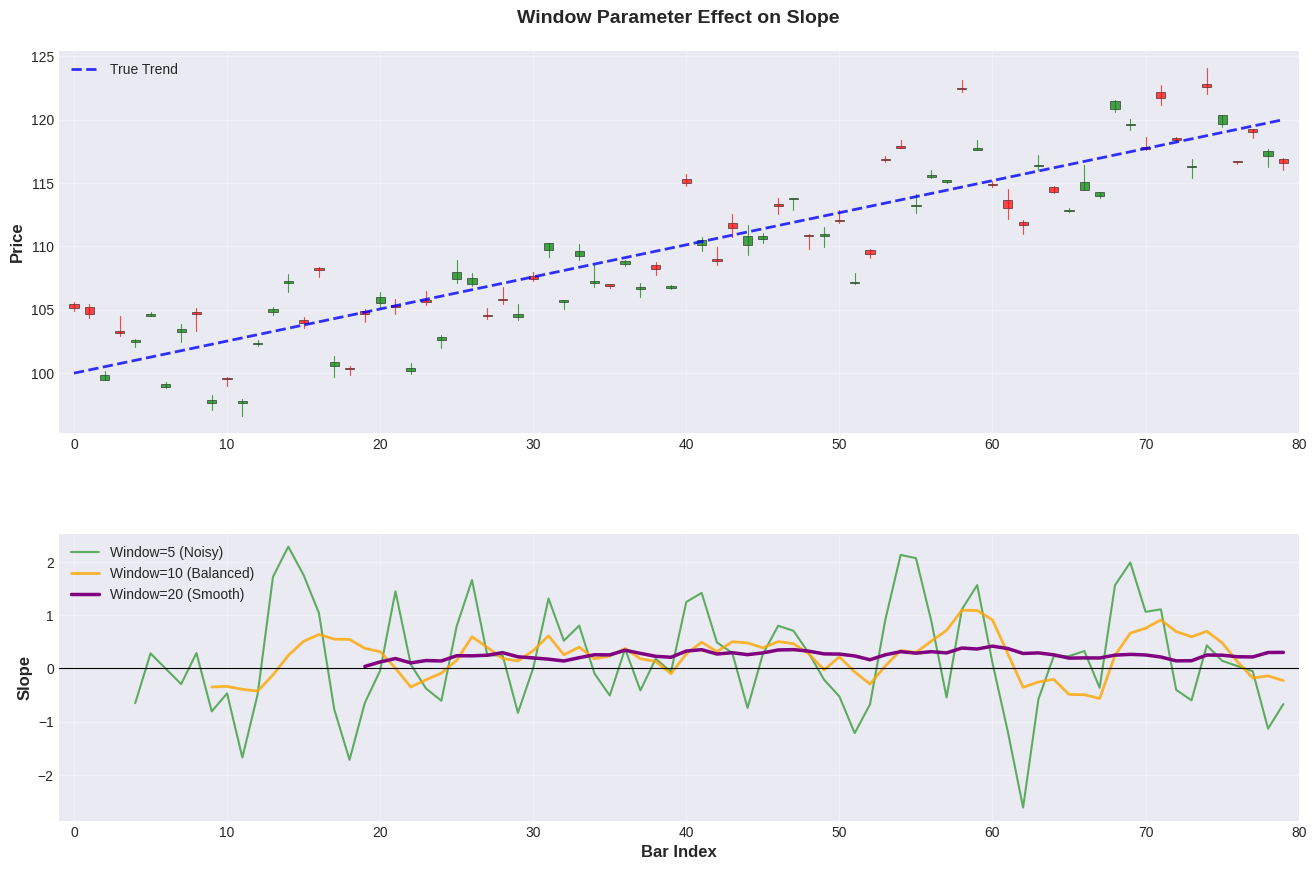

Slope Volatility (Std Dev):
  Window=5:  0.9701 (noisy)
  Window=10: 0.3939
  Window=20: 0.0742 (smooth)


In [3]:
# Noisy trending data
n2 = 80
dates2 = pd.date_range('2024-01-01 10:00', periods=n2, freq='5min')
trend = np.linspace(100, 120, n2)
noise = np.random.randn(n2) * 2.5
closes2 = trend + noise

opens2 = closes2 + np.random.randn(n2) * 0.3
highs2 = np.maximum(opens2, closes2) + np.abs(np.random.randn(n2)) * 0.5
lows2 = np.minimum(opens2, closes2) - np.abs(np.random.randn(n2)) * 0.5
volumes2 = 1000 + np.abs(np.random.randn(n2)) * 200

df2 = pd.DataFrame({'open': opens2, 'high': highs2, 'low': lows2, 'close': closes2, 'volume': volumes2}, index=dates2)

result_w5 = slope(df2["close"], window=5)
result_w10 = slope(df2["close"], window=10)
result_w20 = slope(df2["close"], window=20)

# Plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 1, height_ratios=[2, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Candlesticks
for i in range(len(df2)):
    color = 'green' if df2['close'].iloc[i] >= df2['open'].iloc[i] else 'red'
    ax1.plot([i, i], [df2['low'].iloc[i], df2['high'].iloc[i]], color=color, linewidth=0.8, alpha=0.7)
    height = abs(df2['close'].iloc[i] - df2['open'].iloc[i])
    if height < 0.05: height = 0.12
    bottom = min(df2['open'].iloc[i], df2['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.7))

ax1.plot(trend, 'b--', linewidth=2, label='True Trend', alpha=0.8)
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Window Parameter Effect on Slope', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df2))

# Extract slope values and use integer indices
slope_w5 = result_w5.values
slope_w10 = result_w10.values
slope_w20 = result_w20.values

ax2.plot(range(len(slope_w5)), slope_w5, 'green', linewidth=1.5, alpha=0.6, label='Window=5 (Noisy)')
ax2.plot(range(len(slope_w10)), slope_w10, 'orange', linewidth=2, alpha=0.8, label='Window=10 (Balanced)')
ax2.plot(range(len(slope_w20)), slope_w20, 'purple', linewidth=2.5, label='Window=20 (Smooth)')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Slope', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(-1, len(df2))

plt.tight_layout()
plt.show()

print('Slope Volatility (Std Dev):')
print(f'  Window=5:  {result_w5.std():.4f} (noisy)')
print(f'  Window=10: {result_w10.std():.4f}')
print(f'  Window=20: {result_w20.std():.4f} (smooth)')

## Scenario 3: Trend Acceleration
Detect when trends speed up or slow down

/tmp/sselcuk/ipykernel_1244539/1542656736.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


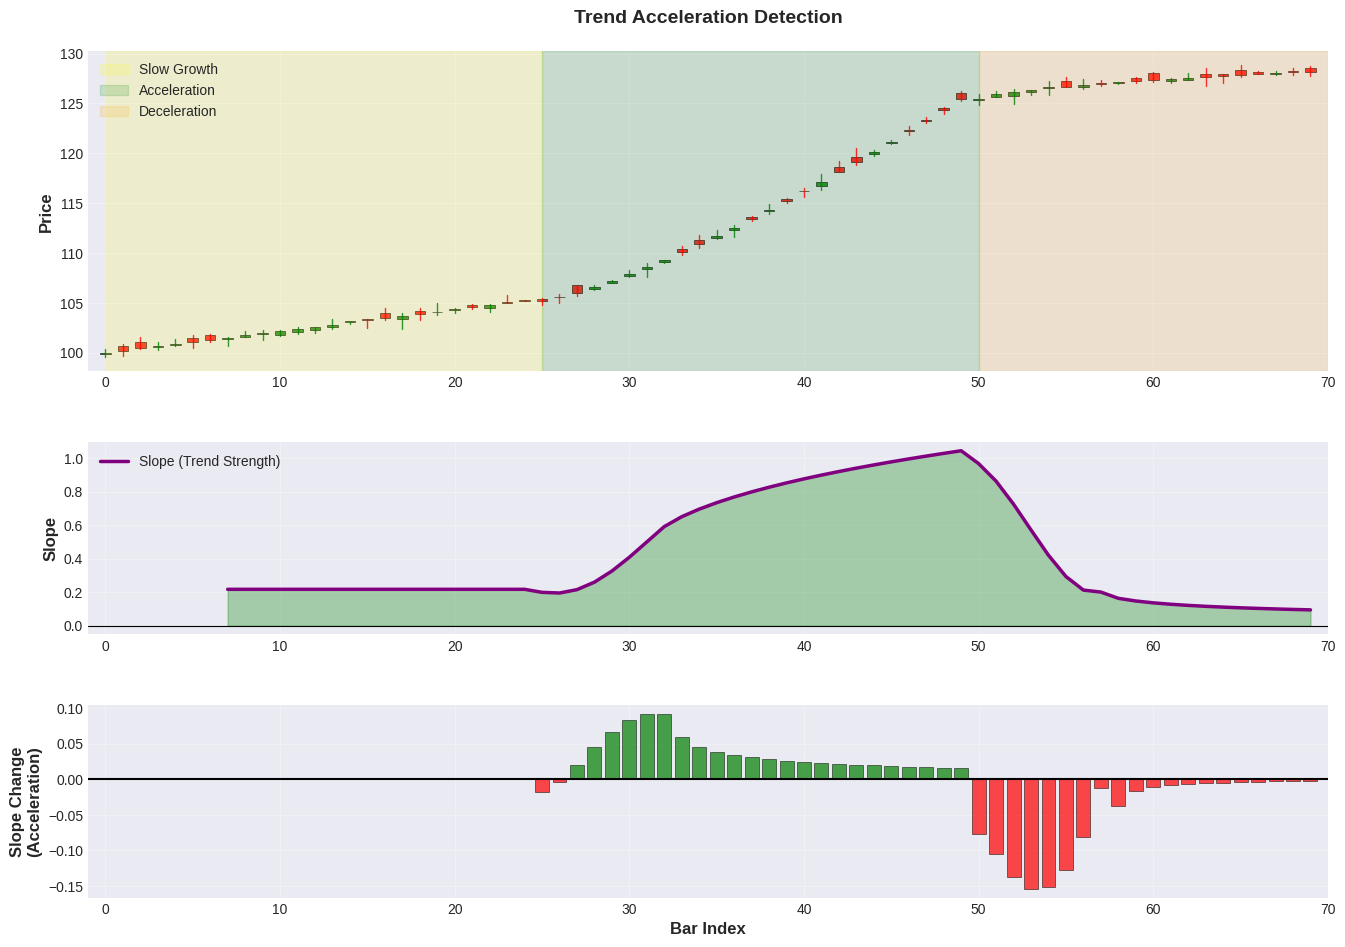

Max slope: 1.0440 at bar 2024-01-01 15:05:00


In [4]:
# Price with acceleration phases
n3 = 70
dates3 = pd.date_range('2024-01-01 11:00', periods=n3, freq='5min')
t = np.linspace(0, 10, n3)
slow = 100 + 1.5 * t[:25]
accel = slow[-1] + 4 * (t[25:50] - t[25]) ** 1.3
decel = accel[-1] + 1.5 * (t[50:] - t[50]) ** 0.6
closes3 = np.concatenate([slow, accel, decel])

opens3 = closes3 + np.random.randn(n3) * 0.3
highs3 = np.maximum(opens3, closes3) + np.abs(np.random.randn(n3)) * 0.4
lows3 = np.minimum(opens3, closes3) - np.abs(np.random.randn(n3)) * 0.4
volumes3 = 1000 + np.abs(np.random.randn(n3)) * 200

df3 = pd.DataFrame({'open': opens3, 'high': highs3, 'low': lows3, 'close': closes3, 'volume': volumes3}, index=dates3)
result3 = slope(df3["close"], window=8)
slope_change = result3.diff()

# Plot
fig = plt.figure(figsize=(16, 11))
gs = GridSpec(3, 1, height_ratios=[2.5, 1.5, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Candlesticks
for i in range(len(df3)):
    color = 'green' if df3['close'].iloc[i] >= df3['open'].iloc[i] else 'red'
    ax1.plot([i, i], [df3['low'].iloc[i], df3['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(df3['close'].iloc[i] - df3['open'].iloc[i])
    if height < 0.05: height = 0.1
    bottom = min(df3['open'].iloc[i], df3['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

ax1.axvspan(0, 25, alpha=0.15, color='yellow', label='Slow Growth')
ax1.axvspan(25, 50, alpha=0.15, color='green', label='Acceleration')
ax1.axvspan(50, 70, alpha=0.15, color='orange', label='Deceleration')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Trend Acceleration Detection', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df3))

# Slope - use integer indices
slope_vals = result3.values
ax2.plot(range(len(slope_vals)), slope_vals, 'purple', linewidth=2.5, label='Slope (Trend Strength)')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.fill_between(range(len(df3)), 0, slope_vals, 
                  where=(slope_vals > 0), alpha=0.3, color='green')
ax2.set_ylabel('Slope', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(-1, len(df3))

# Acceleration
slope_change_vals = slope_change.values
colors_acc = ['green' if s > 0 else 'red' for s in slope_change_vals]
ax3.bar(range(len(df3)), slope_change_vals, color=colors_acc, alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Slope Change\n(Acceleration)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(df3))

plt.tight_layout()
plt.show()

print(f'Max slope: {result3.max():.4f} at bar {result3.idxmax()}')

## Scenario 4: Trading Strategy
Trend-following using slope thresholds

/tmp/sselcuk/ipykernel_1244539/1411896296.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


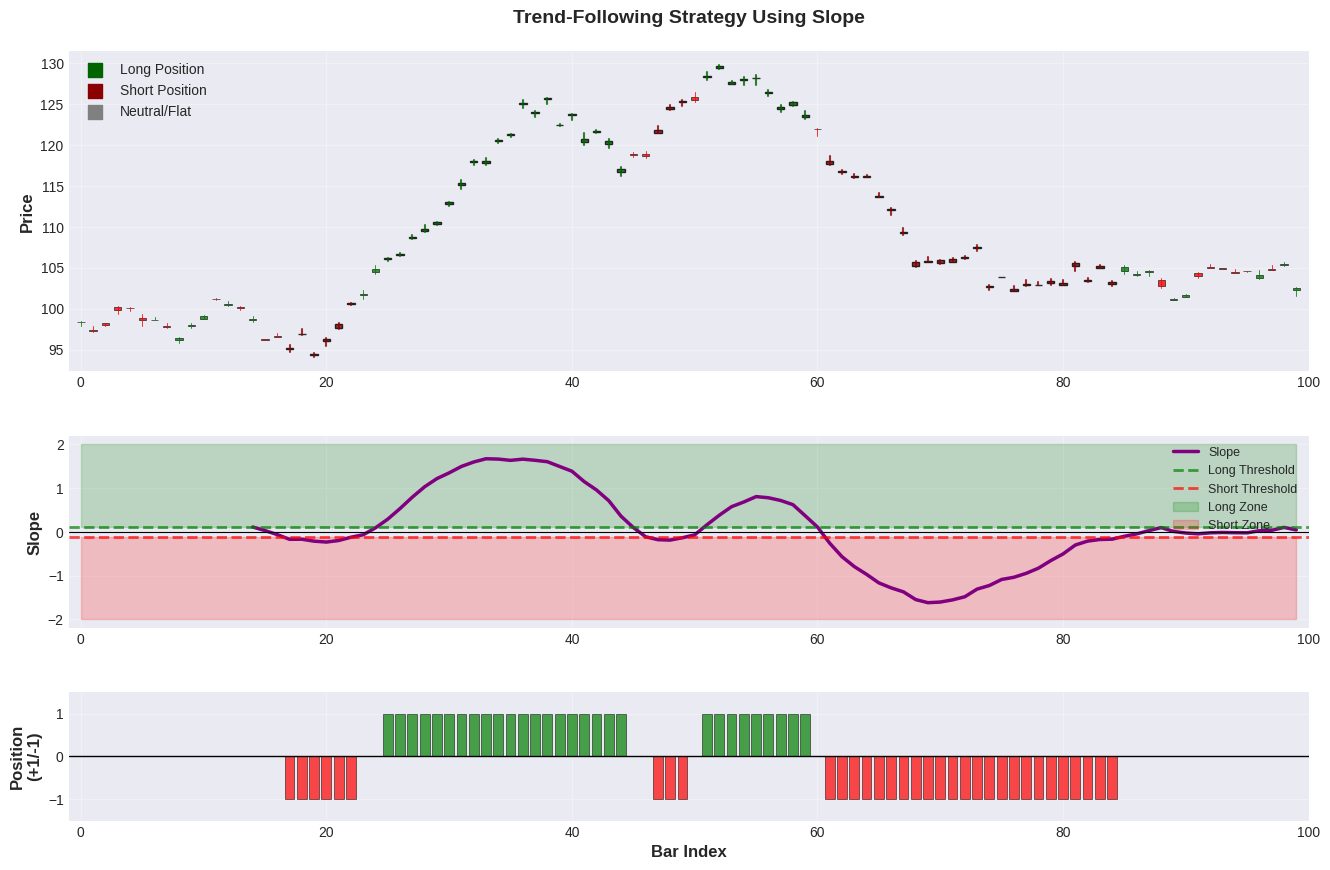

Long:     29 bars (29.0%)
Short:    33 bars (33.0%)
Neutral:  24 bars (24.0%)


In [5]:
# Realistic price data
np.random.seed(789)
n4 = 100
dates4 = pd.date_range('2024-01-01 09:30', periods=n4, freq='5min')
returns = np.random.randn(n4) * 0.015
returns[20:35] += 0.012  # Uptrend
returns[55:70] -= 0.012  # Downtrend
closes4 = 100 * np.exp(np.cumsum(returns))

opens4 = closes4 + np.random.randn(n4) * 0.2
highs4 = np.maximum(opens4, closes4) + np.abs(np.random.randn(n4)) * 0.3
lows4 = np.minimum(opens4, closes4) - np.abs(np.random.randn(n4)) * 0.3
volumes4 = 1000 + np.abs(np.random.randn(n4)) * 200

df4 = pd.DataFrame({'open': opens4, 'high': highs4, 'low': lows4, 'close': closes4, 'volume': volumes4}, index=dates4)
result4 = slope(df4["close"], window=15)

threshold = 0.12
long = result4 > threshold
short = result4 < -threshold
neutral = (result4 >= -threshold) & (result4 <= threshold)

# Plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 1, height_ratios=[2.5, 1.5, 1], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Candlesticks with position overlay
for i in range(len(df4)):
    if long.iloc[i]:
        color = 'darkgreen'
        lw = 1.5
    elif short.iloc[i]:
        color = 'darkred'
        lw = 1.5
    else:
        color = 'green' if df4['close'].iloc[i] >= df4['open'].iloc[i] else 'red'
        lw = 0.7
    
    ax1.plot([i, i], [df4['low'].iloc[i], df4['high'].iloc[i]], color=color, linewidth=lw, alpha=0.8)
    height = abs(df4['close'].iloc[i] - df4['open'].iloc[i])
    if height < 0.05: height = 0.08
    bottom = min(df4['open'].iloc[i], df4['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, 
                                  edgecolor='black', linewidth=0.5 if lw < 1 else 1, alpha=0.8))

ax1.scatter([], [], color='darkgreen', s=100, label='Long Position', marker='s')
ax1.scatter([], [], color='darkred', s=100, label='Short Position', marker='s')
ax1.scatter([], [], color='gray', s=100, label='Neutral/Flat', marker='s')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Trend-Following Strategy Using Slope', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df4))

# Slope with thresholds - use integer indices
slope_vals4 = result4.values
ax2.plot(range(len(slope_vals4)), slope_vals4, 'purple', linewidth=2.5, label='Slope')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(threshold, color='green', linestyle='--', linewidth=2, label='Long Threshold', alpha=0.7)
ax2.axhline(-threshold, color='red', linestyle='--', linewidth=2, label='Short Threshold', alpha=0.7)
ax2.fill_between(range(len(df4)), threshold, 2, alpha=0.2, color='green', label='Long Zone')
ax2.fill_between(range(len(df4)), -threshold, -2, alpha=0.2, color='red', label='Short Zone')
ax2.set_ylabel('Slope', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=9)
ax2.set_xlim(-1, len(df4))

# Position
position = pd.Series(0, index=df4.index)
position[long] = 1
position[short] = -1
colors_pos = ['green' if p == 1 else 'red' if p == -1 else 'gray' for p in position]
ax3.bar(range(len(df4)), position, color=colors_pos, alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Position\n(+1/-1)', fontsize=12, fontweight='bold')
ax3.set_ylim(-1.5, 1.5)
ax3.axhline(0, color='black', linestyle='-', linewidth=1)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(df4))

plt.tight_layout()
plt.show()

print(f'Long:    {long.sum():3d} bars ({long.sum()/len(df4)*100:.1f}%)')
print(f'Short:   {short.sum():3d} bars ({short.sum()/len(df4)*100:.1f}%)')
print(f'Neutral: {neutral.sum():3d} bars ({neutral.sum()/len(df4)*100:.1f}%)')

## Key Takeaways

**Slope Interpretation:**
- **Slope > 0**: Uptrend (bullish)
- **Slope < 0**: Downtrend (bearish)
- **Slope ≈ 0**: Consolidation
- **|Slope|**: Trend strength

**Window Effects:**
- **Small (5-10)**: Responsive, noisy, good for short-term
- **Large (20-30)**: Smooth, reliable, better for trend following

**Advanced Uses:**
1. **Acceleration**: `slope.diff()` shows trend speed changes
2. **Divergence**: Compare price peaks with slope peaks
3. **Multi-timeframe**: Use different windows for confirmation
4. **Trend strength**: Absolute value = conviction

**Performance:**
- **50-100x faster** than scipy.linregress (Numba-optimized)
- Can process 10,000+ bars in milliseconds

**Best Practices:**
- Combine with momentum indicators (RSI, MACD)
- Use stop-losses (slope can stay positive during drawdowns)
- Adjust thresholds per asset volatility
- Test on multiple timeframes (1min, 5min, 1h, daily)

**Trading Guidelines:**
- **Trend Following**: Enter when slope crosses threshold
- **Mean Reversion**: Fade extreme slopes (> 2 std devs)
- **Divergence**: Watch for slope weakening while price extends
- **Filter**: Only trade when |slope| > minimum threshold

## Feature Showcase: Safety & Configuration

In [6]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator import slope

# 1. Configuration with .Config()
print("--- Custom slope Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_slope = slope.Config(window=10).make()
print(f"Created: {custom_slope}")

# 2. Validation Safety
print("\n--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (infinite values)
    invalid_data = pd.Series([1.0, float('inf')]) # Infinite
    print("Attempting calculation with invalid inputs...")
    slope(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected:\n  {e}")

--- Custom slope Configuration ---
Created: slope(window=10)

--- Input Validation Safety ---
Attempting calculation with invalid inputs...
✓ Validator caught error as expected:
  Validation failed for parameter 'data' in 'slope' (Finite): Data must be finite (contains Inf)
